# XRay image binary classification with Torch neural network

Example notebook for chest x-ray classification model

Dataset: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia.
Please ensure you made available the dataset in this pod prior to executing this notebook. You can achieve by either performing an upload using jupyter or by running the download function from the s3-buckets notebook (providing you uploaded using aws cli tool the dataset to the train-test-validation bucket.

### Imports

In [1]:
import torch
import torch.nn as nn
import onnx
import onnxruntime
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PIL import Image

# Filter harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
from datetime import datetime

### Verify data directories structure

In [4]:
print(os.listdir("."))

['torch_add_libraries.ipynb', 'torch_xray_demo_cpu.onnx', 'rhods-variant-x-ray-predict-pneumonia-torch-training.ipynb', 'torch_test_endpoint.ipynb', 'torch_dependencies.ipynb', '.ipynb_checkpoints', 'demo_Adam Lomboy_2523_1966-08-19_2016-03-18.jpeg']


In [5]:
print(os.listdir("../dataset"))

print(os.listdir("../dataset/test"))

print(os.listdir("../dataset/train/"))

print(os.listdir("../dataset/val/"))

['val', 'train', 'test']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


### Check an image in the "NORMAL" training set

NORMAL


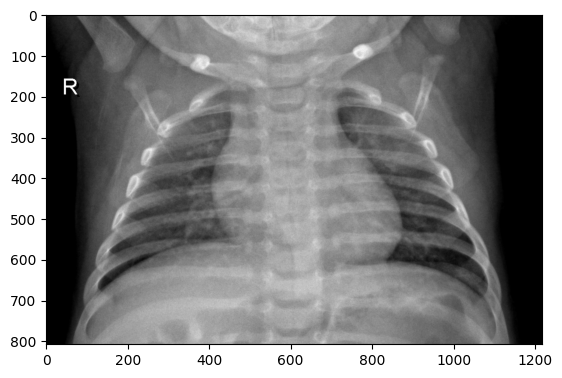

In [6]:
img_name = '../dataset/train/NORMAL/NORMAL2-IM-0588-0001.jpeg'

with Image.open(img_name) as img_normal:
    #display(im)
    print('NORMAL')
    plt.imshow(img_normal, cmap='gray')
    plt.show()

### Check an image in the PNEUMONIA training set

PNEUMONIA


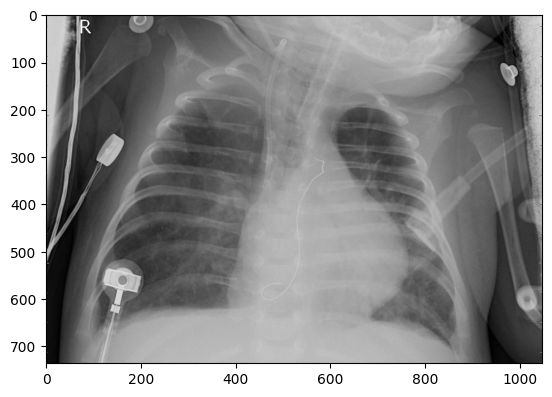

In [7]:
img_name = '../dataset/train/PNEUMONIA/person63_bacteria_306.jpeg'

with Image.open(img_name) as img_pneumonia:
    print('PNEUMONIA')
    plt.imshow(img_pneumonia, cmap='gray')
    plt.show()
    #display(img_pneumonia)

### Initialize variables

In [8]:
# dimensions of our images.
img_width, img_height = 150, 150

In [9]:
train_data_dir = '../dataset/train'
validation_data_dir = '../dataset/val'
test_data_dir = '../dataset/test'

nb_train_samples = 5217
nb_validation_samples = 17
epochs = 20
batch_size = 16

In [10]:
train_transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.GaussianBlur(kernel_size = (3,3), sigma = (0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
#        mean = [0.5, 0.5, 0.5],
#        std = [0.5, 0.5, 0.5]
    )
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
#        mean = [0.5, 0.5, 0.5],
#        std = [0.5, 0.5, 0.5]
    )
])

test_transform = transforms.Compose([
    transforms.Resize(150),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
#        mean = [0.5, 0.5, 0.5],
#        std = [0.5, 0.5, 0.5]
    )
])

In [11]:
# training dataset
train_dataset = datasets.ImageFolder(root = train_data_dir,
                                     transform = train_transform
                                    )
# validation dataset
valid_dataset = datasets.ImageFolder(root = validation_data_dir,
                                     transform = valid_transform
                                    )
# test dataset 
test_dataset = datasets.ImageFolder(root = test_data_dir,
                                     transform = test_transform
                                    )

# training data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
# validation data loaders
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
# test data loaders
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [12]:
train_dataset.classes

['NORMAL', 'PNEUMONIA']

### Create (Sequential) Model

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 17 * 17, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
model = CNNModel()

### Check information about the model

In [16]:
model.to(device)

CNNModel(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=18496, out_features=64, bias=True)
    (12): ReLU()
    (13): Dropout(p=0.5, inplace=False)
    (14): Linear(in_features=64, out_features=2, bias=True)
  )
)

### Train the model

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

In [18]:
# A function to encapsulate the training loop
def batch_gd(model, criterion, optimizer, train_loader, valid_loader, epochs):
    train_losses = np.zeros(epochs)
    valid_losses = np.zeros(epochs)

    for it in range(epochs):
        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
        
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
        
            train_loss.append(loss.item())
        
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
        
        model.eval()
        valid_loss = []
        for inputs, targets in valid_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            valid_loss.append(loss.item())
        valid_loss = np.mean(valid_loss)
        
        # Save losses
        train_losses[it] = train_loss
        valid_losses[it] = valid_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
            Validation Loss: {valid_loss:.4f}, Duration: {dt}')
    
    return train_losses, valid_losses

In [19]:
train_losses, valid_losses = batch_gd(model, criterion, optimizer, train_loader, valid_loader, epochs)

Epoch 1/20, Train Loss: 0.2392,             Validation Loss: 0.5083, Duration: 0:00:57.926449
Epoch 2/20, Train Loss: 0.1369,             Validation Loss: 0.6761, Duration: 0:00:57.605628
Epoch 3/20, Train Loss: 0.1318,             Validation Loss: 0.6585, Duration: 0:00:58.482616
Epoch 4/20, Train Loss: 0.1140,             Validation Loss: 0.4184, Duration: 0:00:58.169158
Epoch 5/20, Train Loss: 0.1085,             Validation Loss: 0.6020, Duration: 0:00:58.839319
Epoch 6/20, Train Loss: 0.1030,             Validation Loss: 1.0040, Duration: 0:00:58.092956
Epoch 7/20, Train Loss: 0.0993,             Validation Loss: 0.4872, Duration: 0:00:58.511251
Epoch 8/20, Train Loss: 0.0929,             Validation Loss: 0.6345, Duration: 0:00:57.617769
Epoch 9/20, Train Loss: 0.0905,             Validation Loss: 0.5089, Duration: 0:00:58.451673
Epoch 10/20, Train Loss: 0.0856,             Validation Loss: 0.5031, Duration: 0:00:58.222033
Epoch 11/20, Train Loss: 0.0843,             Validation Los

### Visualize the training results

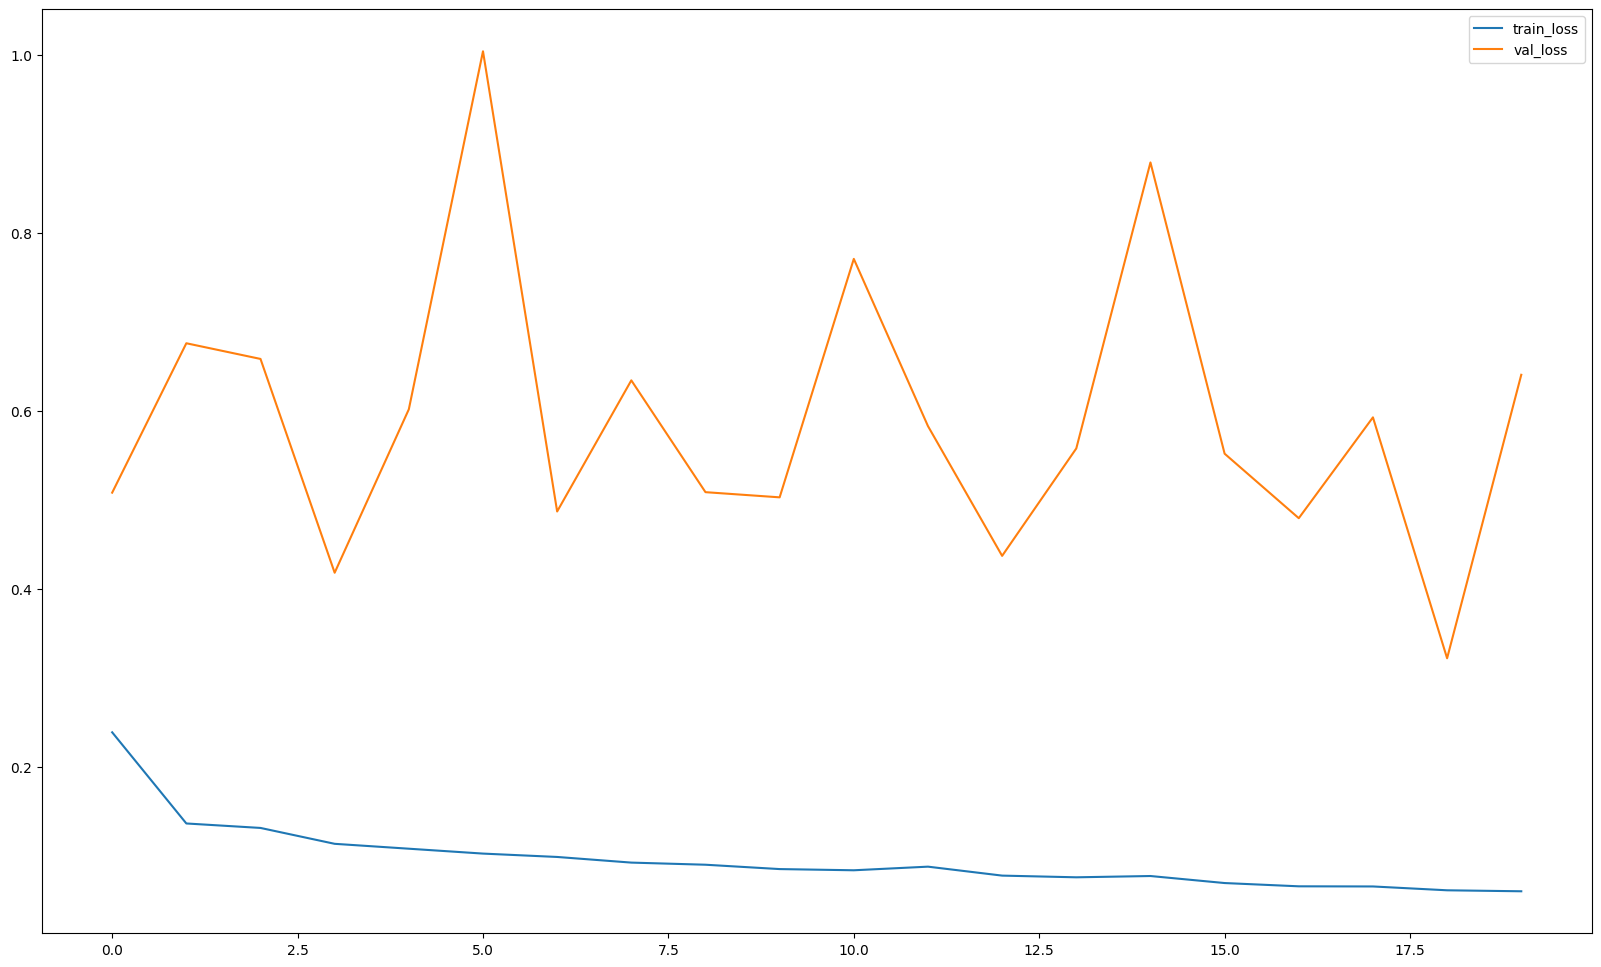

In [20]:
plt.figure(figsize=(20,12))
plt.plot(train_losses, label='train_loss')
plt.plot(valid_losses, label='val_loss')
plt.legend()
plt.show()

In [21]:
# Accuracy

model.eval()
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

train_acc = n_correct / n_total


n_correct = 0.
n_total = 0.
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)

    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9845, Test acc: 0.7660


In [22]:
from sklearn.metrics import classification_report,confusion_matrix, matthews_corrcoef

In [23]:
# get all predictions in an array and plot confusion matrix

y_test = np.array(test_dataset.targets)
p_test = np.array([])
for inputs, targets in test_loader:
    # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    _, predictions = torch.max(outputs, 1)
  
    # update p_test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

In [24]:
print(classification_report(y_test, p_test, target_names = ['Normal (Class 0)','Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.96      0.39      0.56       234
Pneumonia (Class 1)       0.73      0.99      0.84       390

           accuracy                           0.77       624
          macro avg       0.84      0.69      0.70       624
       weighted avg       0.82      0.77      0.73       624



In [25]:
matthews_corrcoef(y_test, p_test)

0.5137830903923016

In [26]:
import seaborn as sns

In [27]:
labels = test_dataset.class_to_idx
labels

{'NORMAL': 0, 'PNEUMONIA': 1}

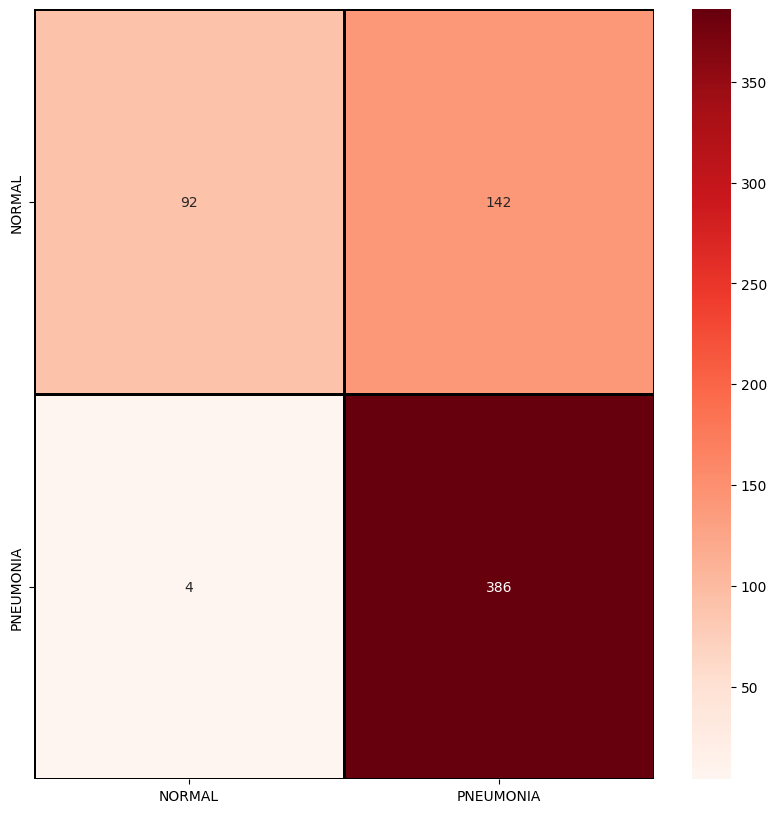

In [28]:
cm = confusion_matrix(y_test, p_test)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm, cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', xticklabels = labels, yticklabels = labels);

### Export the model to ONNX format and then deploy it inside RHODS' Model Mesh Service

In [29]:
train_dataset[0][0].shape

torch.Size([3, 150, 150])

In [30]:
torch.onnx.export(model,torch.randn(1,3,150,150).to(device),'torch_xray_demo_cpu.onnx')

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [31]:
import boto3
import botocore

In [32]:
#Retrieve AWS access from the data connection attached to the workbench
aws_access_key_id = os.environ["AWS_ACCESS_KEY_ID"]
aws_secret_access_key = os.environ["AWS_SECRET_ACCESS_KEY"]
endpoint_url = os.environ["AWS_S3_ENDPOINT"]
bucket_name = os.environ["AWS_S3_BUCKET"]
region_name = os.environ["AWS_DEFAULT_REGION"]

In [33]:
#S3 ODF Bucket
s3_client = boto3.client(service_name = 's3',
                      aws_access_key_id = aws_access_key_id,
                      aws_secret_access_key = aws_secret_access_key,
                      region_name = region_name,
                      endpoint_url = endpoint_url,
                      config = botocore.client.Config(signature_version = 's3'))

In [34]:
s3_client.upload_file('torch_xray_demo_cpu.onnx', bucket_name, 'xraydemo/torch_xray_demo_cpu.onnx')

In [35]:
response = s3_client.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')
    print(f'{bucket}')

Existing buckets:
  data-bucket-9634ea62-4700-4b74-9c1d-732cd35e14ab
{'Name': 'data-bucket-9634ea62-4700-4b74-9c1d-732cd35e14ab', 'CreationDate': datetime.datetime(2024, 1, 10, 3, 36, 18, tzinfo=tzlocal())}


In [36]:
s3_resource = boto3.resource(service_name= 's3',
                             endpoint_url = endpoint_url,
                             aws_access_key_id = aws_access_key_id,
                             aws_secret_access_key = aws_secret_access_key,
                             region_name = region_name,
                             #config=botocore.client.Config(signature_version = 's3')
                            )

my_bucket = s3_resource.Bucket(bucket_name)

for my_bucket_object in my_bucket.objects.all():
    print(my_bucket_object.key)

xraydemo/torch_xray_demo_cpu.onnx


### Test the model deployed in RHODS' Model Mesh Service.

In [37]:
file_name = './demo_Adam Lomboy_2523_1966-08-19_2016-03-18.jpeg'

In [38]:
img = Image.open(file_name)

In [39]:
# we need 3 channels for the 
img_conv=img.convert(mode="RGB")

In [40]:
img_tensor_conv = test_transform(img_conv)

In [41]:
# expand the tensor with one more dimension that stands in for the batch
img_tensor_conv = torch.unsqueeze(img_tensor_conv, 0)

In [42]:
img_tensor_conv.shape

torch.Size([1, 3, 150, 150])

In [43]:
img_tensor_conv = img_tensor_conv.to(device)

In [44]:
# Verify #2 with the local compiled model
t_pred = model.forward(img_tensor_conv)

In [45]:
predicted = torch.max(t_pred.data, 1)[1]

In [46]:
test_dataset.classes[predicted.item()]

'PNEUMONIA'